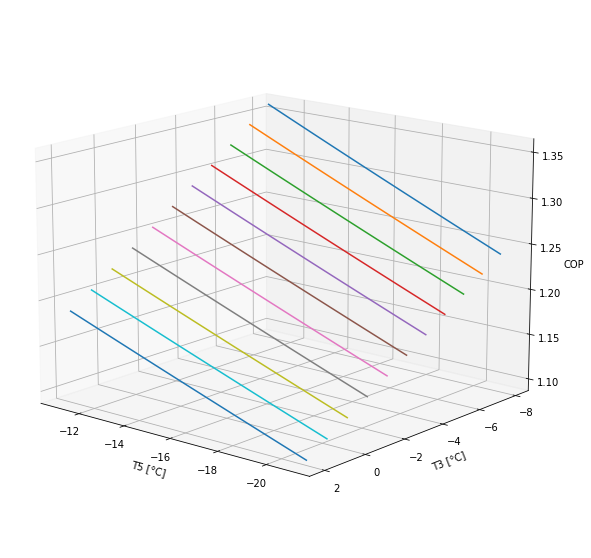

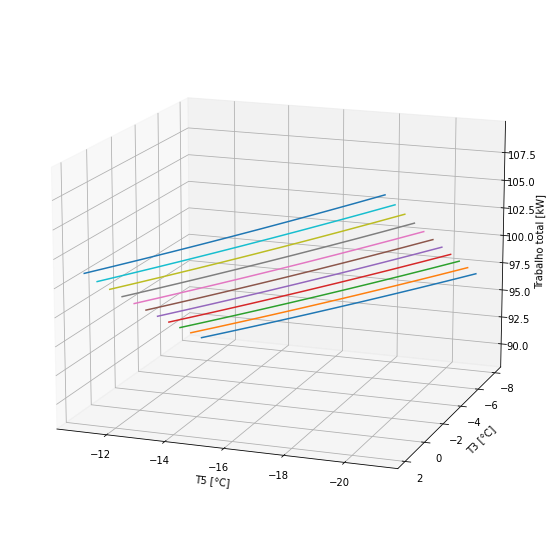

In [7]:
from CoolProp.CoolProp import PropsSI as CP
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import get_test_data
import math
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

#Listas
T3_lista = []
T5_lista = []
Wcomp_total_lista = []
COP_lista = []
cont = []

#Lista de temperaturas de condensação
for i in range (-21, -10, 1):
    cont.append(i+273.15)

#Dados do problema
Pfrig = 120 * 1000 #[W]
T1 = -80 + 273.15 #[K]
T7 = 35 + 273.15 #[K]
fluid_high = 'R717'
fluid_low = 'R41'
n = 1.1
drop_suc = 12000 #[Pa]
drop_desc = 24000 #[Pa]

#Pressão crítica do fluido superior
P_crit_high = CP('PCRIT', fluid_high)

#Ciclo inferior
P1 = CP('P', 'T', T1, 'Q', 1, fluid_low) 
h1 = CP('H', 'T', T1, 'Q', 1, fluid_low)
ha = h1
Pa = P1 - drop_suc
Ta = CP('T', 'H', ha, 'P', Pa, fluid_low)
Pb = Pa
Tb = Ta + 4 #superaquecimento de 4°C na admissão
vb = 1 / CP('D', 'T', Tb, 'P', Pb, fluid_low)

#Ciclo superior
P7 = CP('P', 'T', T7, 'Q', 0, fluid_high)
P6 = P7
Py = P6 + drop_desc
h7 = CP('H', 'T', T7, 'Q', 0, fluid_high)
h8 = h7

#Loop nos dois ciclos - variação das temperaturas do trocador central
for T3 in range (-8, 3, 1):
    T3 = T3 + 273.15
    #Ciclo inferior
    P3 = CP('P', 'T', T3, 'Q', 0 , fluid_low)
    P2 = P3
    Pc = P2 + drop_desc
    vc = (Pb * vb ** n / Pc)**(1 / n)
    h3 = CP('H', 'T', T3, 'Q', 0, fluid_low)
    h4 = h3
    hc = CP('H', 'P', Pc, 'D', 1 / vc, fluid_low)
    h2 = hc
    m_flow_low = Pfrig / (h1 - h4)
    #Trabalho específico no compressor do ciclo inferior
    w_low = n / (n-1) * Pb * vb * ((Pc/Pb)**((n-1)/n) - 1)
    #Trabalho no compressor do ciclo inferior
    Wcomp_low = m_flow_low * w_low
    #Calor trocado no trocador central
    Qcond_low =  m_flow_low * (h2 - h3)
    for T5 in cont:
        #Ciclo superior
        Qevap_high = Qcond_low
        P5 = CP('P', 'T', T5, 'Q', 1, fluid_high)
        h5 = CP('H', 'T', T5, 'Q', 1, fluid_high)
        hw = h5
        Pw = P5 - drop_suc
        Tw = CP('T', 'H', hw, 'P', Pw, fluid_high)
        Px = Pw
        Tx = Tw + 4 #superaquecimento de 4°C na admissão
        vx = 1 / CP('D', 'T', Tx, 'P', Px, fluid_high)
        m_flow_high = Qevap_high / (h5 - h8)
        #Verificação da pressão crítica
        if P_crit_high > P6:
            T3_lista.append(T3 - 273.15)
            T5_lista.append(T5 - 273.15)
            #Trabalho específico no compressor do ciclo superior
            w_high = n / (n-1) * Px * vx * ((Py/Px)**((n-1)/n) - 1)
            #Trabalho no compressor do ciclo superior
            Wcomp_high = m_flow_high * w_high
            #Trabalho total
            Wcomp_total = Wcomp_low + Wcomp_high
            Wcomp_total_lista.append(Wcomp_total / 1000)
            #COP
            COP = Pfrig / Wcomp_total
            COP_lista.append(COP)
        else:
            print ('A pressão P6 = {:0.2f} kPa (T3 = {:0.2f}°C, T5 = {:0.2f}°C) é maior do que a ' 
               'pressão crítica do {} e, por isso, o ponto não foi incluído no gráfico'
                   .format(P6/1000,T3-273.15,T5-273.15,fluid_high))

if len(T3_lista) !=0:
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1, projection ='3d')
    for i in range (0, len(COP_lista), len(cont)):
        x1line = []
        y1line = []
        z1line = []
        for j in range (i, i + len(cont), 1):
            y1line.append(T3_lista[i])
            x1line.append(T5_lista[j])
            z1line.append (COP_lista[j])
        ax.set_xlabel('T5 [°C]', size = 10)
        ax.set_ylabel('T3 [°C]', size = 10)
        ax.set_zlabel('COP', size = 10)
        ax.view_init(15, 130)
        ax.plot3D(x1line, y1line, z1line)
    plt.show()
else:
    print ('Todos os pontos são inválidos')
    
if len(T3_lista) !=0:
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1, projection ='3d')
    for i in range (0, len(Wcomp_total_lista), len(cont)):
        x1line = []
        y1line = []
        z1line = []
        for j in range (i, i + len(cont), 1):
            y1line.append(T3_lista[i])
            x1line.append(T5_lista[j])
            z1line.append (Wcomp_total_lista[j])
        ax.set_xlabel('T5 [°C]', size = 10)
        ax.set_ylabel('T3 [°C]', size = 10)
        ax.set_zlabel('Trabalho total [kW]', size = 10)
        ax.view_init(15, 110)
        ax.plot3D(x1line, y1line, z1line)
    plt.show()
else:
    print ('Todos os pontos são inválidos')
